# Simple Super Image Resolution Test with the Deconvolutional Layer

This notebook will document the process of taking an image dataset blurring with a convolution operation with a 2 by 2 kernel. The blurred image will be taken as an input for the Deconvolution Neural Network where the network will try to predict the unblurred image.

## Import relevant libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from DeconvDft2dLayer import DeconvDft2dLayer as Deconv2D

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import os
from random import random

## Defining functions for blurring images

`get_imgs_from_dir(ds_path, target_size)` gets the image dataset from the specific directory

`easy_two_by_two_blur(ds_path)` applies a simple blur to the images in the given path and outputs it to a folder, in the same directory, called two_by_two_blur

In [2]:
def get_imgs_from_dir(ds_path, color_mode='grayscale', target_size=[256, 256]):
    img_names = os.listdir(ds_path)
    imgs = []

    for img_name in img_names:
        if img_name[-4:] == '.png':
            img_path = os.path.join(ds_path, img_name)
            img = tf.keras.utils.load_img(img_path,
                                          color_mode=color_mode,
                                          target_size=target_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
            imgs.append(img)
    aug_imgs = imgs

    imgs_tensor = tf.constant(aug_imgs, dtype=tf.float32)
    x_train = imgs_tensor / 255.0

    return x_train

def easy_two_by_one_blur_ds(ds_path):
    # get data that needs to be transformed
    print('Loading data')
    imgs = get_imgs_from_dir(ds_path, color_mode='rgb')
    print('Data Loaded!')
    
    
    # set up convolution kernel
    k = np.array([[1],
                  [0.5]], dtype=np.float32)
    k0 = np.zeros(k.shape, dtype=np.float32)

    kr = np.array([k, k0, k0], dtype=np.float32)
    kg = np.array([k0, k, k0], dtype=np.float32)
    kb = np.array([k0, k0, k], dtype=np.float32)

    kf = np.array([kr, kg, kb])
    kf = tf.transpose(kf, perm=[2, 3, 1, 0])

    kf = tf.constant(kf, dtype=tf.float32)
    
    
    # apply convolution operation to the images
    y = tf.nn.conv2d(imgs, kf, strides=[1, 1, 1, 1], padding='SAME')

    img_names = os.listdir(ds_path)
    base_path = ds_path + '/../two_by_one_blur/'

    if not os.path.exists(base_path):
        os.makedirs(base_path)
    
    # Save blurred images to new directory two_by_one_blur
    for i in range(y.shape[0]):
        if img_names[i][-4:] == '.png':
            img_path = base_path + img_names[i]
            tf.keras.utils.save_img(img_path, y[i])
            
    print('Blurring process complete! Check the directory')
    

## Applying the blurring operation to the dataset


In [3]:
ds_path = 'SimpleSuperResDeconvTest/high_res/'

# NB! uncomment if you don't have the two_by_two_blur folder
easy_two_by_one_blur_ds(ds_path)

Loading data
Data Loaded!
Blurring process complete! Check the directory


## Visualising input and output data

Let's plot the high res and blurred images to double-check that the convolution operation did blur the image

134.png


(-0.5, 255.5, 255.5, -0.5)

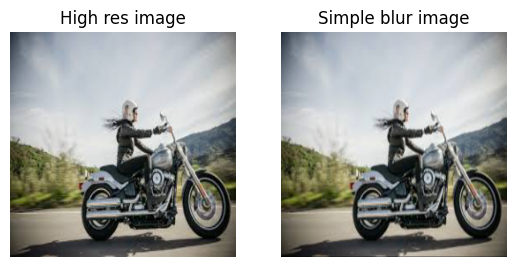

In [4]:
img_name = os.listdir('SimpleSuperResDeconvTest/high_res/')[40]

img_hres = mpimg.imread('SimpleSuperResDeconvTest/high_res/' + img_name)
img_blur = mpimg.imread('SimpleSuperResDeconvTest/two_by_one_blur/' + img_name)

print(img_name)

plt.figure()

ax = plt.subplot(1, 2, 1)
plt.imshow(img_hres)
ax.set_title('High res image')
plt.axis('off')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_blur)
ax.set_title('Simple blur image')
plt.axis('off')

## Loading datasets into notebook

Now that the input and output data is read we can load both of these datasets into this notebook

In [5]:
print('Loading input data....')
x_train = get_imgs_from_dir('SimpleSuperResDeconvTest/two_by_one_blur/')[0]
print('Loading output data....')
y_train = get_imgs_from_dir('SimpleSuperResDeconvTest/high_res/')[0]
print('Data has been successfully loaded!')

Loading input data....
Loading output data....
Data has been successfully loaded!


## Defining the Deep Learning Model

Now that the data has been loaded into the notebook successfully, the deep learning model that will be trained on the data can be defined. We will use TensorFlow Keras functional API to define the model

In [6]:
x_train = tf.reshape(x_train, (1, 256, 256, 1))
y_train = tf.reshape(y_train, (1, 256, 256, 1))

inputs = keras.Input(shape=(256, 256, 1))
outputs = Deconv2D((2, 1))(inputs)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.SGD()
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 deconv_dft2d_layer (DeconvD  (None, 256, 256, 1)      1         
 ft2dLayer)                                                      
                                                                 
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


## Training the Model

In [7]:
w_before = model.layers[1].w.numpy()
history = model.fit(x_train, y_train, epochs=10)
w_after = model.layers[1].w.numpy()

Epoch 1/10
1/1 [==============================] - 0s 427ms/step - loss: 0.0170
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0170
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0178
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0194
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0203
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0202
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0200
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0201
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0200
Epoch 10/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0201


## Plotting history and kernels

Here we will plot the history of the mean absolute error with respect to the number of epochs. The kernels before and after training will also be displayed

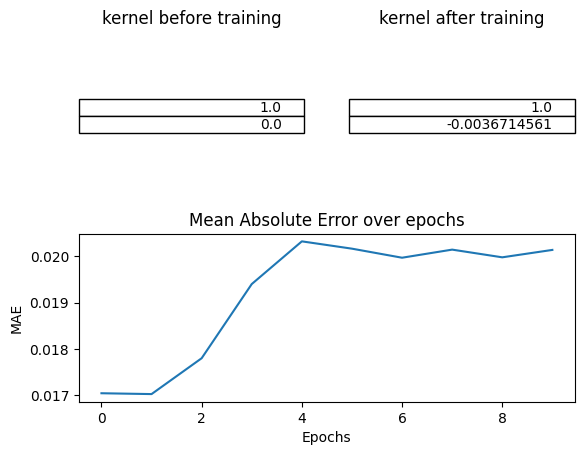

In [11]:
# Reshaping kernels to their correct shapes
pad_w = tf.constant([[0, 0], [1, 0]])

w_after_ = tf.pad(w_after, pad_w, mode='CONSTANT', constant_values=1)
w_after_ = tf.reshape(w_after_, (2, 1))

w_before_ = tf.pad(w_before, pad_w, mode='CONSTANT', constant_values=1)
w_before_ = tf.reshape(w_before_, (2, 1))

plt.figure()

ax = plt.subplot(2, 2, 1)
ax.table(w_before_.numpy(), loc='center')
ax.set_title('kernel before training')
ax.axis('tight')
ax.axis('off')

ax = plt.subplot(2, 2, 2)
ax.table(w_after_.numpy(), loc='center')
ax.set_title('kernel after training')
ax.axis('tight')
ax.axis('off')

ax = plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
ax.set_title('Mean Absolute Error over epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')

plt.show()

## Check if the output was predicted correctly

Here we will plot the input data, output data, and what the Deconv NN predicted as the output

(-0.5, 255.5, 255.5, -0.5)

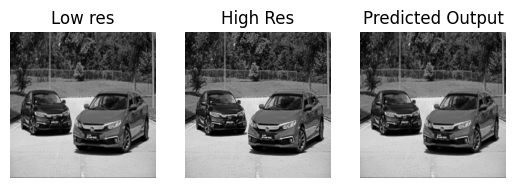

In [9]:
i = 10
x_img = x_train
y_img = y_train

y_pred = model(x_img)

plt.figure()

ax = plt.subplot(1, 3, 1)
plt.imshow(x_img[0], cmap='gray')
ax.set_title('Low res')
plt.axis('off')

ax = plt.subplot(1, 3, 2)
plt.imshow(y_img[0], cmap='gray')
ax.set_title('High Res')
plt.axis('off')

ax = plt.subplot(1, 3, 3)
plt.imshow(y_pred[0], cmap='gray')
ax.set_title('Predicted Output')
plt.axis('off')

## Discussion

The DNN seems to predict the desired output quite well. It minimises the Mean Absolute Error after a few epochs which is normal when you take into account that this problem it is solving is trivial. Next we will compare it to a simple CNN and see how it fairs against it

## Checking MAE for DNN output against low res image

In [10]:
y_pred_diff = tf.subtract(y_train, y_pred)
y_pred_ae = tf.abs(y_pred_diff)
y_pred_mae = tf.reduce_mean(y_pred_ae)

low_res_diff = tf.subtract(y_train, x_train)
low_res_ae = tf.abs(low_res_diff)
low_res_mae = tf.reduce_mean(low_res_ae)


print('MAE between high res and DNN OUTPUT:\t' + str(y_pred_mae))
print('MAE between high res and LOW RES:\t' + str(low_res_mae))

MAE between high res and DNN OUTPUT:	tf.Tensor(0.019985318, shape=(), dtype=float32)
MAE between high res and LOW RES:	tf.Tensor(0.0170473, shape=(), dtype=float32)
